# Introduction

Analyzing healthcare spending patterns offers valuable information for providers, insurers, and policymakers. This project examines public Medicare claims data.  The goal is to analyze expenditures across various demographics and diagnosis-related groups (DRGs). We use the 2008 Medicare Inpatient Claims Public Use File (PUF) to study the cost distribution within a select group of DRGs.

Our analysis focuses on how expenses vary based on factors like age and gender.  We also explore the connection between healthcare spending and length of stay. To share our findings, we will use data visualization techniques with Python libraries like Matplotlib and Seaborn.

Our dataset has certain limitations due to data suppression.  This helps maintain patient confidentiality. As such, we limit our analysis to the DRGs with a high number of claims in the PUF and a low rate of suppression. Keep this constraint in mind when interpreting our analysis results.

In the upcoming sections, we outline the steps taken in the following order.   Data preparation, exploratory data analysis, and interpretation of our findings.  Insights gained from this project can help guide decision-making, leading to more efficient healthcare systems.

# Data Preparation

## Load the dataset and necessary Python libraries 

In [1]:
# Load necessary libraries
from scipy.stats import chi2_contingency
from matplotlib.patches import Rectangle
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare

# Get the absolute path of the directory containing the script file
script_dir = os.path.abspath(os.getcwd())

# File paths (relative to the script directory)
data_filepath = os.path.join(
    script_dir, 'datasets/2008_BSA_Inpatient_Claims_PUF.csv')
base_drg_filepath = os.path.join(
    script_dir, 'datasets/Base_DRG_Descriptors.csv')
icd9_filepath = os.path.join(script_dir, 'datasets/ICD9_Descriptors.csv')

# Load CSV files
data = pd.read_csv(data_filepath)
base_drg_df = pd.read_csv(base_drg_filepath)
icd9_df = pd.read_csv(icd9_filepath)

# Join the datasets and rename columns
data = pd.merge(data, base_drg_df[['Base DRG', 'Descriptor']],
                left_on='IP_CLM_BASE_DRG_CD', right_on='Base DRG',
                how='left', suffixes=('_base', '_drg'))
data = data.drop(['Base DRG'], axis=1)
data = data.rename(columns={'Descriptor': 'descriptor_drg'})

data = pd.merge(data, icd9_df[['ICD-9 Procedure Code', 'Descriptor']],
                left_on='IP_CLM_ICD9_PRCDR_CD', right_on='ICD-9 Procedure Code',
                how='left', suffixes=('_icd9', '_proc'))
data = data.drop(['ICD-9 Procedure Code'], axis=1)
data = data.rename(columns={'Descriptor': 'descriptor_icd'})

# Replace missing values'descriptor_icd'
data['descriptor_icd'] = data['descriptor_icd'].fillna(
    'No primary procedure on patient')

## Inspect the dataset for missing values, outliers, or inconsistencies

In this section, we will examine key variables in the dataset to identify any outliers or inconsistencies that may impact the accuracy of our analysis. We will visually inspect each variable using appropriate graphs and validate their values based on the expected categories or ranges.  Some variables are transformed or renamed for clarity or ease of use.

ID Variable (IP_CLM_ID): We will ignore the index variable, since it is not necessary for our aggregate analysis.

Gender Variable (BENE_SEX_IDENT_CD): Next, we will verify that the gender variable contains only valid categories male(1) or female(2). We will also create a bar chart to display the distribution of claims by gender, allowing us to observe any significant imbalances.

Age Variable (BENE_AGE_CAT_CD): We will first inspect the age variable to ensure that it only contains valid categories (1 to 6).  To visualize the distribution of age categories, we will create a bar chart showing the number of claims for each age group.

Base DRG Variable (IP_CLM_BASE_DRG_CD): We will check that the Base DRG variable has valid codes ranging from 1 to 311. To visualize the distribution of DRG codes in the dataset, we will create a bar chart displaying the top 10 most frequent DRG codes. This allows us to focus on the most common DRG codes in the dataset and gain insight into their prevalence.

ICD-9 Primary Procedure Code Variable (IP_CLM_ICD9_PRCDR_CD): We will ensure that the ICD-9 primary procedure code variable contains valid codes (00 to 99) and identify any missing values. To visualize the distribution of DRG codes in the dataset, we will create a bar chart displaying the top 10 most frequent ICD-9 codes. This allows us to focus on the most common DRG codes in the dataset and gain insight into their prevalence.

Length of Stay Variable (IP_CLM_DAYS_CD): We will validate that the length of stay variable contains valid categories (1 to 4). To visualize the distribution of length of stay categories, we will create a bar chart displaying the number of claims for each category.

Amount Variables (IP_DRG_QUINT_PMT_AVG and IP_DRG_QUINT_PMT_CD): We will check that the IP_DRG_QUINT_PMT_CD variable contains valid categories (1 to 5) and verify the values in the IP_DRG_QUINT_PMT_AVG variable. To visualize the relationship between IP_DRG_QUINT_PMT_CD and IP_DRG_QUINT_PMT_AVG, we will create a violin plot for the top 3 most frequent DRG codes.

By closely examining these variables and their distributions, we can ensure the data's accuracy and reliability before proceeding with further analysis. This step is crucial in maintaining the integrity of our research findings and understanding the limitations of our dataset.


### Rename columns

In [2]:
# Define the new column names
new_columns = {
    'IP_CLM_ID': 'id',
    'BENE_SEX_IDENT_CD': 'gender',
    'BENE_AGE_CAT_CD': 'age',
    'IP_CLM_BASE_DRG_CD': 'base_drg',
    'IP_CLM_ICD9_PRCDR_CD': 'icd9',
    'IP_CLM_DAYS_CD': 'length',
    'IP_DRG_QUINT_PMT_AVG': 'payment',
    'IP_DRG_QUINT_PMT_CD': 'quintile'
}

# Rename the columns
data = data.rename(columns=new_columns)
print(data.head())

                    id  gender  age  base_drg  icd9  length  payment  \
0  IP-000022CE4125DBE7       2    4         3  31.0       4    86240   
1  IP-0000417F50942D90       2    5       199   NaN       2     3447   
2  IP-0000865F5457AC0E       1    1       119  54.0       4    34878   
3  IP-00009789630AF474       2    2       128   NaN       2     3007   
4  IP-0000C9D229B79D36       2    2       236  70.0       1     3352   

   quintile                                     descriptor_drg  \
0         4  Extracranial procedures with a principal diagn...   
1         2                                  Diabetes with MCC   
2         5  Hernia procedures except inguinal and femoral ...   
3         2  Esophagitis, gastroenteritis, and miscellaneou...   
4         2  Female Reproductive System Reconstructive Proc...   

                           descriptor_icd  
0  Other Operations On Larynx And Trachea  
1         No primary procedure on patient  
2    Other Operations On Abdominal Reg

### Inspect gender variable

Summary:
 count     588415
unique         2
top       Female
freq      330198
Name: gender, dtype: object
Men: 43.88 %, and Women: 56.12 %


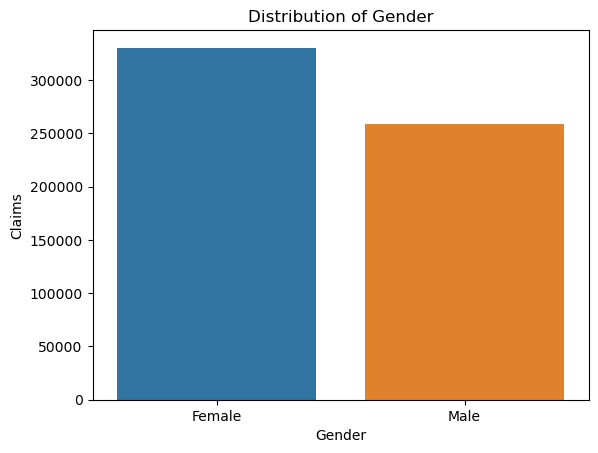

In [3]:
# Transform gender categories
gender_dict = {1: 'Male', 2: 'Female'}
data['gender'] = data['gender'].replace(gender_dict)

# Summary statistics
print('Summary:\n', data['gender'].describe())

# Gender breakdown
gender_counts = data['gender'].value_counts()
gender_percentages = gender_counts / len(data) * 100
print('Men:', round(gender_percentages['Male'], 2), '%, and Women:', round(
    gender_percentages['Female'], 2), '%')

# Visualization: Create a bar chart to display the distribution of gender
sns.countplot(data=data, x='gender')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Claims')

# Display plot
plt.show()

### Inspect age variable

85 and above    122287
Under 65        116080
80-84            94759
75-79            91487
70-74            86205
65-69            77597
Name: age, dtype: int64


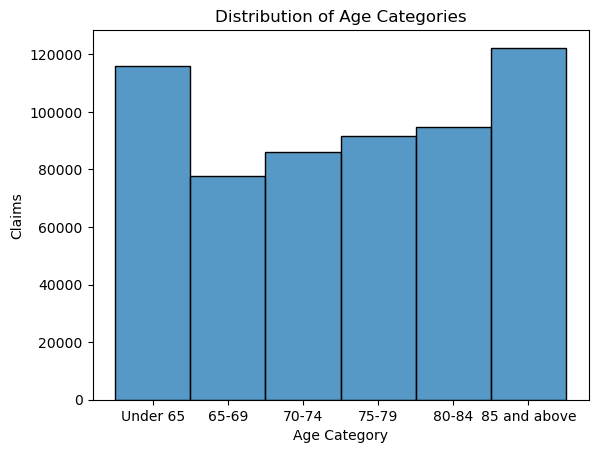

In [4]:
# Transform age categories
age_dict = {
    1: 'Under 65',
    2: '65-69',
    3: '70-74',
    4: '75-79',
    5: '80-84',
    6: '85 and above'
}
data['age'] = data['age'].replace(age_dict)
data['age'] = pd.Categorical(
    data['age'], ['Under 65', '65-69', '70-74', '75-79', '80-84',
                  '85 and above'])

# Check the distribution of age categories (1 to 6)
print(data['age'].value_counts())

# Create a bar chart to display the distribution of age categories
sns.histplot(data['age'], kde=False)
plt.title('Distribution of Age Categories')
plt.xlabel('Age Category')
plt.ylabel('Claims')

# Display plot
plt.show()

### Inspect Base DRG variable

All Base DRG codes are in range


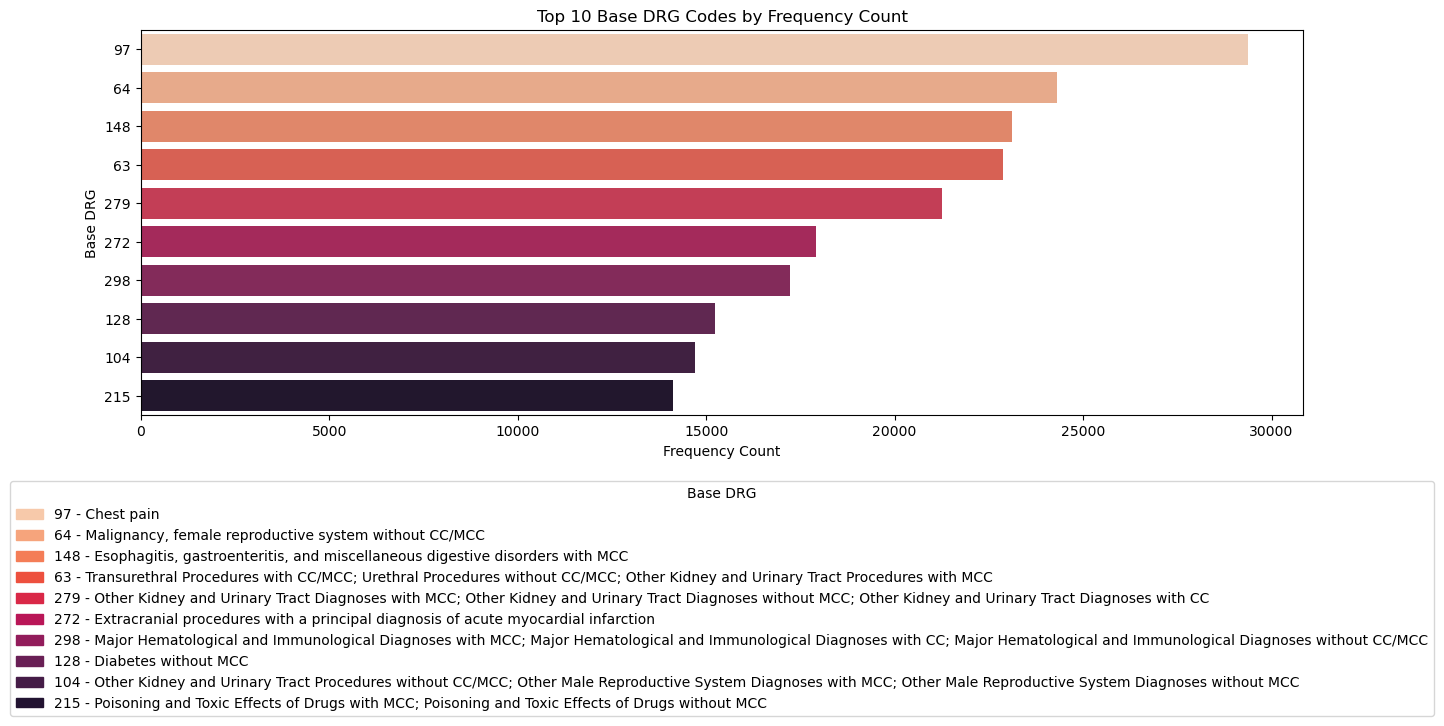

In [5]:
# Check for valid codes (1 to 311)
if data['base_drg'].min() == 1 and data['base_drg'].max() == 311:
    print('All Base DRG codes are in range')

# Get the top 10 Base DRG codes by frequency count
top10_base_drg = data['base_drg'].value_counts().head(
    10).sort_values(ascending=False)

# Subset the descriptor_base_drg column based on the index of top10_base_drg
descriptor_base_drg = data.loc[top10_base_drg.index, 'descriptor_drg']

# Define a color palette with more contrast
colors = sns.color_palette("rocket_r", len(top10_base_drg))

# Create a horizontal barplot of top 10 base_DRG codes and their frequencies
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=top10_base_drg.values, y=top10_base_drg.index, ax=ax,
            orient='h', order=top10_base_drg.index, palette=colors)

# Chart Legend with descriptors
legend_labels = [f'{drg} - {desc}' for drg,
                 desc in zip(top10_base_drg.index, descriptor_base_drg)]
legend_handles = [Rectangle((0, 0), 1, 1, color=color) for color in colors]
ax.legend(legend_handles, legend_labels, title='Base DRG', loc='lower center',
          bbox_to_anchor=(0.5, -0.8), ncol=1,
          fontsize=10)

ax.set_title('Top 10 Base DRG Codes by Frequency Count')
ax.set_xlabel('Frequency Count')
ax.set_ylabel('Base DRG')

plt.show()

### Inspect ICD-9 primary procedure code variable

All ICD9 codes are in range


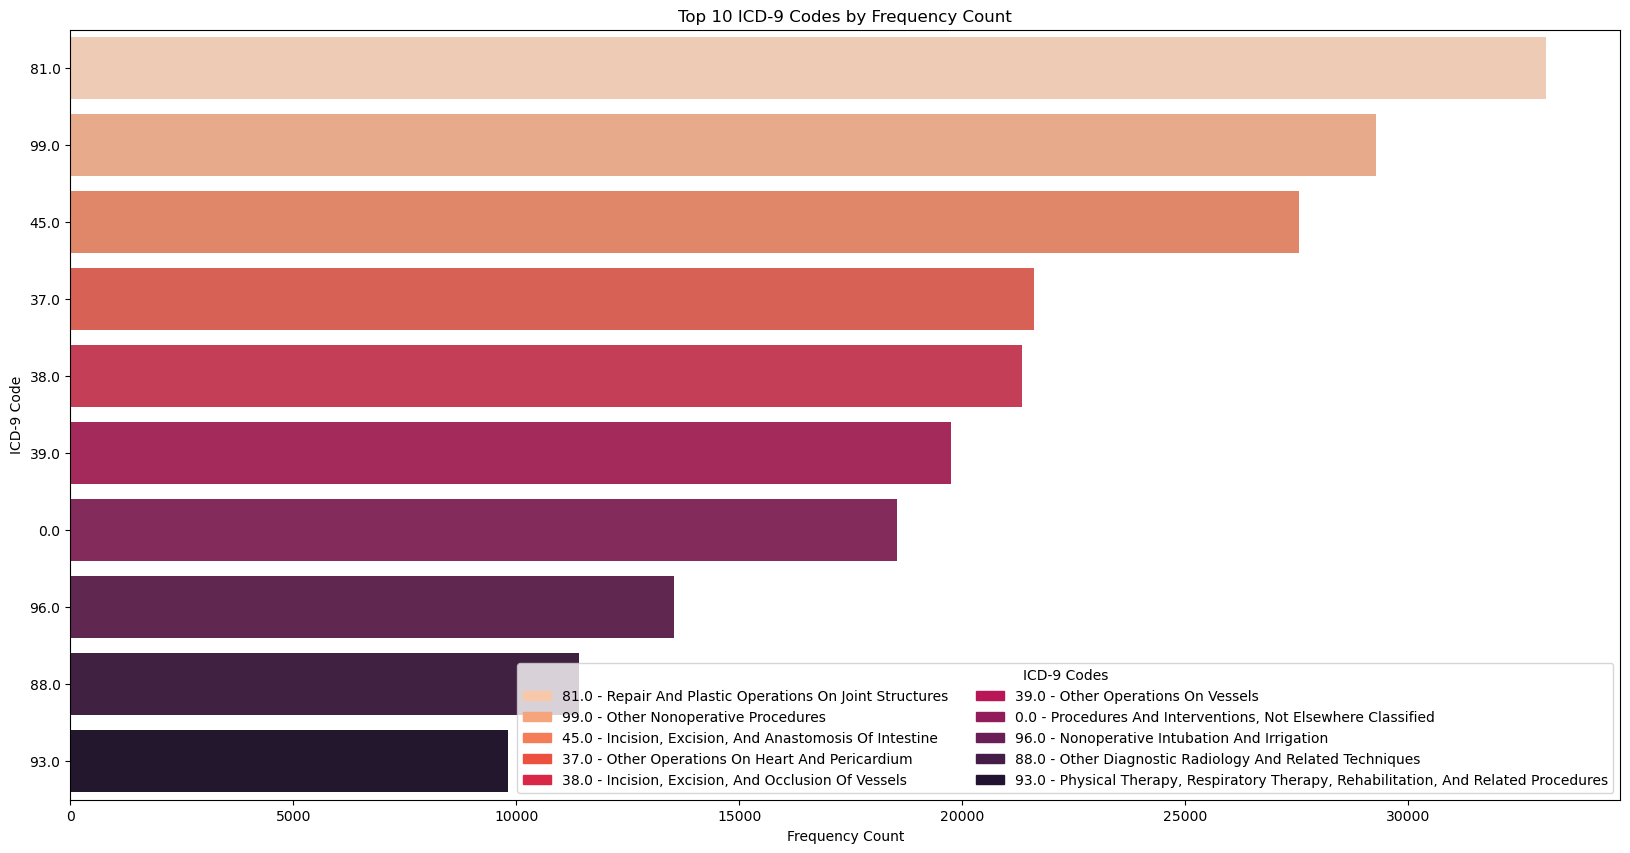

In [6]:
# Check for valid codes (0 to 99)
if data['icd9'].min() == 0 and data['icd9'].max() == 99:
    print('All ICD9 codes are in range')

# Filter out rows with missing ICD9 values
data_filtered = data.dropna(subset=['icd9'])

# Get the top 10 ICD9 codes by frequency count
top10_icd9 = data_filtered.groupby('icd9').size().nlargest(
    10).reset_index(name='valuecount')

# Subset the descriptor_icd9 column based on the index of top10_icd9
descriptor_icd9 = data_filtered.loc[data_filtered['icd9'].isin(
    top10_icd9['icd9']), ['icd9', 'descriptor_icd']].drop_duplicates()

# Merge the top10_icd9 and descriptor_icd9 DataFrames
top10_icd9_merged = top10_icd9.merge(descriptor_icd9, on='icd9')

# Sort the top10_icd9_merged DataFrame by 'valuecount' in descending order
top10_icd9_merged = top10_icd9_merged.sort_values(
    'valuecount', ascending=False)

# Create a horizontal barplot of top 10 ICD9 codes and their frequencies
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x='valuecount', y='icd9', data=top10_icd9_merged, ax=ax,
            orient='h', order=top10_icd9_merged['icd9'], palette=colors)

# Chart Legend with descriptors
legend_labels = [f"{row['icd9']} - {row['descriptor_icd']}" for _,
                 row in top10_icd9_merged.iterrows()]
legend_handles = [Rectangle((0, 0), 1, 1, color=color) for color in colors]
ax.legend(legend_handles, legend_labels,
          title='ICD-9 Codes', loc='lower right', ncol=2)

ax.set_title('Top 10 ICD-9 Codes by Frequency Count')
ax.set_xlabel('Frequency Count')
ax.set_ylabel('ICD-9 Code')

plt.show()

### Inspect length of stay variable

2-4 days          261419
8 or more days    128898
5-7 days          122073
1 day              76025
Name: length, dtype: int64


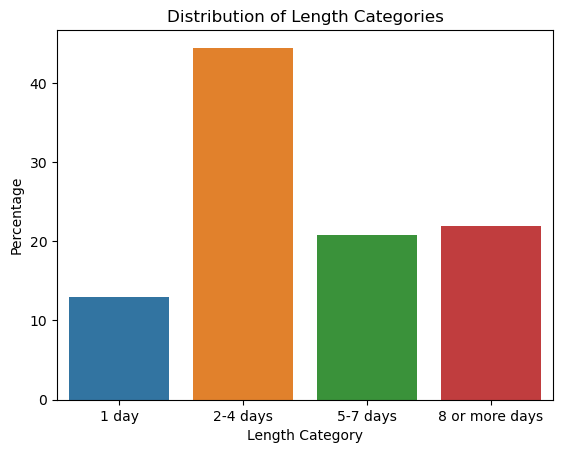

In [7]:
# Transform length categories
length_dict = {1: '1 day',
               2: '2-4 days',
               3: '5-7 days',
               4: '8 or more days'}
data['length'] = data['length'].replace(length_dict)
data['length'] = pd.Categorical(
    data['length'], ['1 day', '2-4 days', '5-7 days', '8 or more days'])

# Check the distribution of length categories (1 to 4)
print(data['length'].value_counts())

# Calculate the percentage of observations in each length category
length_perc = (data['length'].value_counts(normalize=True)
               * 100).rename('percentage').reset_index()

# Create a bar chart to display the distribution of length categories
sns.barplot(x='index', y='percentage', data=length_perc)
plt.title('Distribution of Length Categories')
plt.xlabel('Length Category')
plt.ylabel('Percentage')

# Display plot
plt.show()

### Inspect claims amount variables

The data contains quintile values ranging from 1 to 5
Summary statistics for payments: 
 count    588415.000000
mean       9312.621422
std       10482.707298
min           0.000000
25%        4008.000000
50%        6352.000000
75%       10760.000000
max      329467.000000
Name: payment, dtype: float64


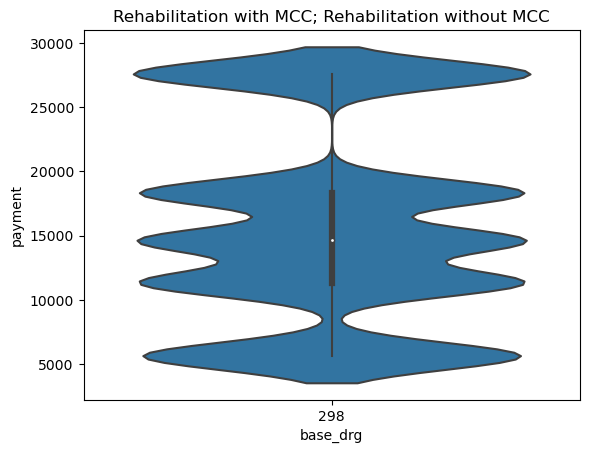

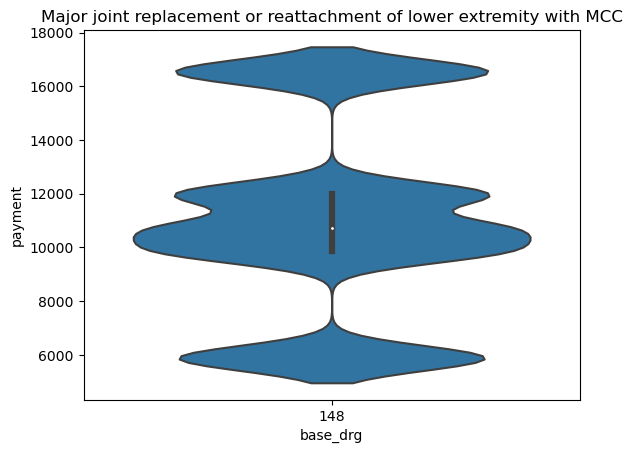

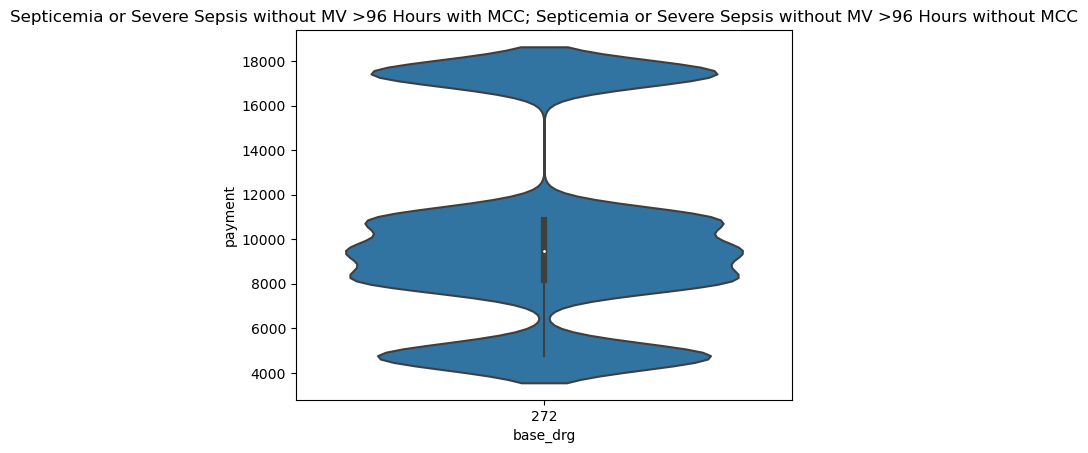

In [8]:
# Check for valid categories (1 to 5) for IP_DRG_QUINT_PMT_CD
if (data['quintile'].unique() >= 1).all() and (data['quintile'].unique() <= 5).all():
    print('The data contains quintile values ranging from 1 to 5')

# Check for valid values in IP_DRG_QUINT_PMT_AVG
print('Summary statistics for payments: \n', data['payment'].describe())

# Group the data by base_drg and sum the quint_avg_payment for each group
drg_pay_sum = data.groupby('base_drg')['payment'].sum()

# Sort the drg_pay_sum series in descending order and get the top three DRGs
top_drgs = drg_pay_sum.sort_values(ascending=False).index[:3]

# Plot top 3 in drg_pay_sum
for drg in top_drgs:
    subset_drg = data[data['base_drg'] == drg]
    sns.violinplot(x='base_drg', y='payment', data=subset_drg)
    plt.title(data[data['base_drg'] == drg]['descriptor_drg'].iloc[0])
    plt.show()

## Data filtering
Based on the dataset documentation, the rate of suppression of claims is much higher for DRGs that are uncommon among Medicare beneficiaries.  The documentation also includes suggested filter parameters. To ensure that the statistical results derived from the dataset are reliable, we will focus on the 69 DRGs with 2,000 or more claims. On average, less than 10% of claims from these DRGs have been suppressed. This reduces the number of observations by approximately 20%.

In [9]:
# Drop DRGs with less than 2000 claims
drg_counts = data['base_drg'].value_counts()
drg_filter = drg_counts[drg_counts >= 2000].index
data = data[data['base_drg'].isin(drg_filter)]

# Show filtered results
original_data = pd.read_csv(data_filepath)
print(f"Original data shape: {original_data.shape}")
print(f"Filtered data shape: {data.shape}")

Original data shape: (588415, 8)
Filtered data shape: (471431, 10)


# Exploratory data analysis

## Chi-squared Tests

In [10]:
# Gender Distribution
observed_percentages = data['gender'].value_counts(normalize=True)
expected_percentages = pd.Series([0.5, 0.5], index=['Female', 'Male'])

chi2_statistic, p_value = chisquare(observed_percentages, expected_percentages)

print("Chi-squared goodness of fit for gender test:")
print(f"Observed percentages:\n{observed_percentages}")
print(f"Expected percentages:\n{expected_percentages}")
print(f"Chi-squared statistic: {chi2_statistic:.2f}")
print(f"P-value: {p_value:.4f}\n")

#

# Create a list of variable pairs
variable_pairs = [('gender', 'age'), ('gender', 'length'), ('age', 'length')]

# Create a table of normalized p-values
p_values = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'P-value'])

for pair in variable_pairs:
    contingency_table = pd.crosstab(
        index=data[pair[0]], columns=data[pair[1]], normalize='all')
    chi2_statistic, p_value, dof, expected_values = chi2_contingency(
        contingency_table)
    row = {'Variable 1': pair[0], 'Variable 2': pair[1],
           'P-value': f'{p_value:.2f}'.rstrip('0').rstrip('.')}
    p_values = pd.concat([p_values, pd.DataFrame([row])])

# Print the table of normalized p-values
print("Table of normalized p-values for variable pairs:")
print(p_values)

Chi-squared goodness of fit for gender test:
Observed percentages:
Female    0.567795
Male      0.432205
Name: gender, dtype: float64
Expected percentages:
Female    0.5
Male      0.5
dtype: float64
Chi-squared statistic: 0.02
P-value: 0.8921

Table of normalized p-values for variable pairs:
  Variable 1 Variable 2 P-value
0     gender        age       1
0     gender     length       1
0        age     length       1


## Distribution of healthcare expenditures


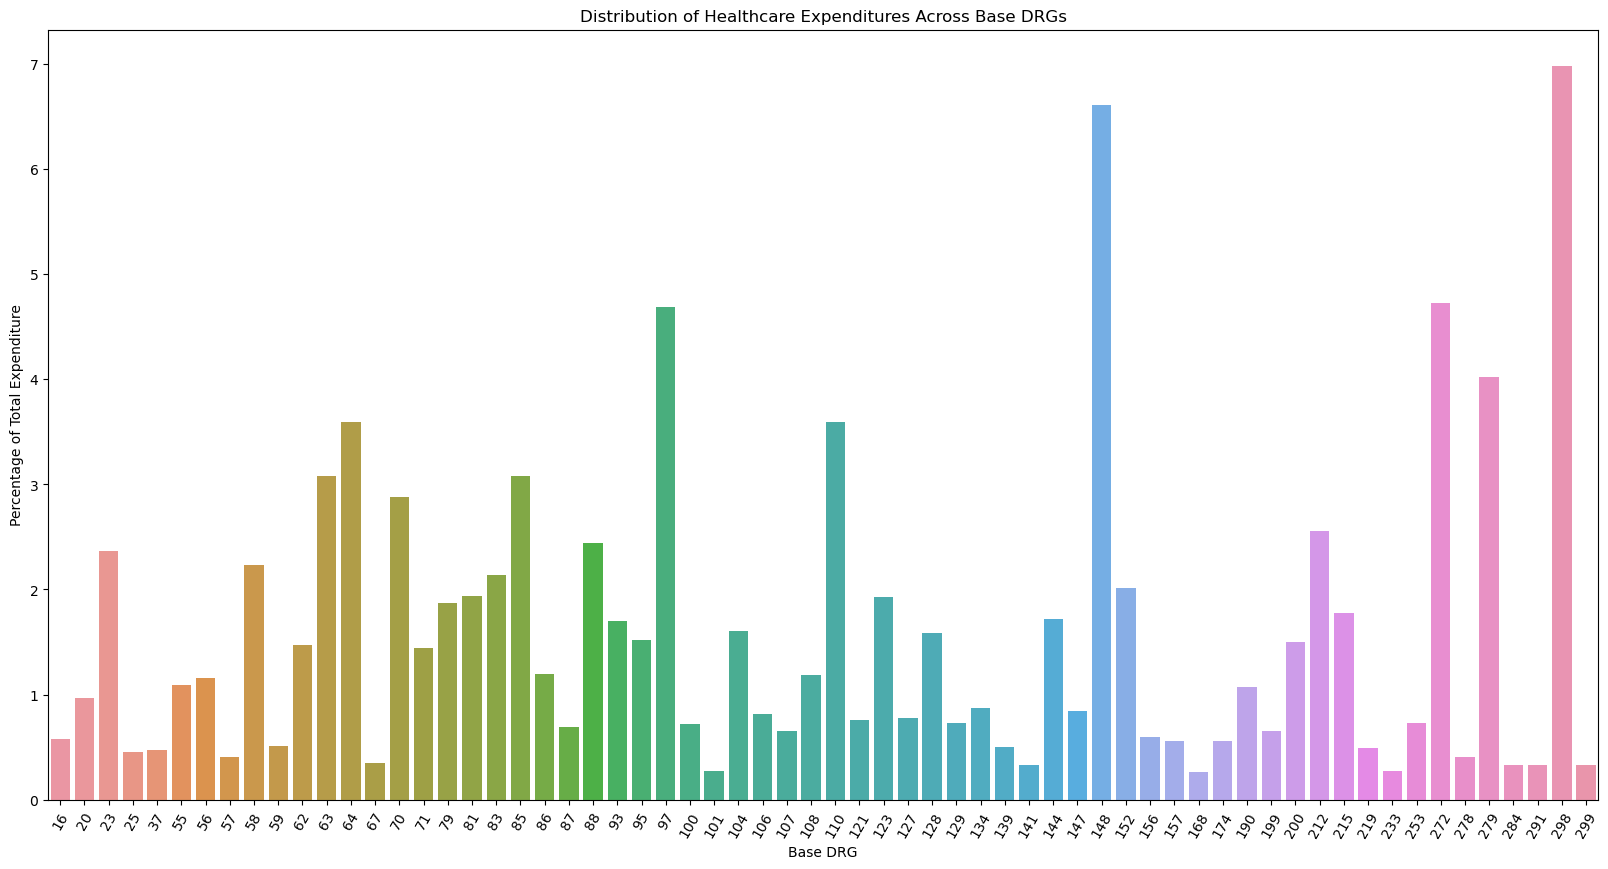

In [11]:
# Group the data by DRG code
grouped_data = data.groupby('base_drg')['payment'].sum()

# Calculate the percentage of total expenditure for each DRG
total_expenditure = grouped_data.sum()
percentage_expenditure = (grouped_data / total_expenditure) * 100

# Reset the index of the percentage_expenditure DataFrame
percentage_expenditure = percentage_expenditure.reset_index()

# Visualize the distribution as horizontal bar chart
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=percentage_expenditure, x='base_drg', y='payment', ax=ax)
plt.title('Distribution of Healthcare Expenditures Across Base DRGs')
plt.xlabel('Base DRG')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.ylabel('Percentage of Total Expenditure')
plt.show()

## Distribution of expenditures by demographic factors

### Expenditures by gender

Percentage of total expenditures:
gender
Female    55.327563
Male      44.672437
Name: payment, dtype: float64
Percentage of population:
Female    56.779465
Male      43.220535
Name: gender, dtype: float64


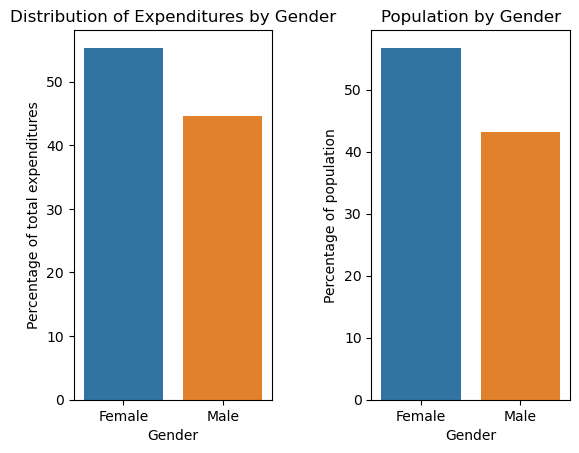

In [12]:
# Calculate the total expenditures for each gender
gender_pay_sum = data.groupby('gender')['payment'].sum()

# Calculate the percentage of total expenditures for each gender
gender_pay_pct = gender_pay_sum / gender_pay_sum.sum() * 100

# Calculate the percentage of population for each gender
gender_pop_pct = data['gender'].value_counts(normalize=True) * 100

# Print the percentage of total expenditures for each gender
print('Percentage of total expenditures:')
print(gender_pay_pct)

# Print the percentage of population for each gender
print('Percentage of population:')
print(gender_pop_pct)

# Plot the percentage of total expenditures for each gender using a bar plot
plt.subplot(1, 2, 1)
sns.barplot(x=gender_pay_pct.index, y=gender_pay_pct)
plt.xlabel('Gender')
plt.ylabel('Percentage of total expenditures')
plt.title('Distribution of Expenditures by Gender')

# Plot the percentage of population for each gender using a bar plot
plt.subplot(1, 2, 2)
sns.barplot(x=gender_pop_pct.index, y=gender_pop_pct)
plt.xlabel('Gender')
plt.ylabel('Percentage of population')
plt.title('Population by Gender')

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.5)

# Show the plots
plt.show()

### Expenditures by age

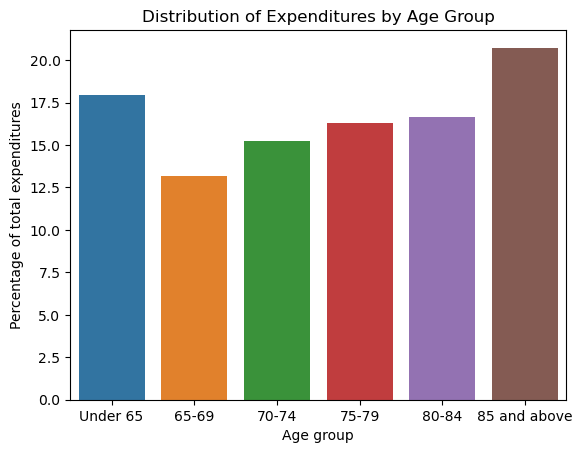

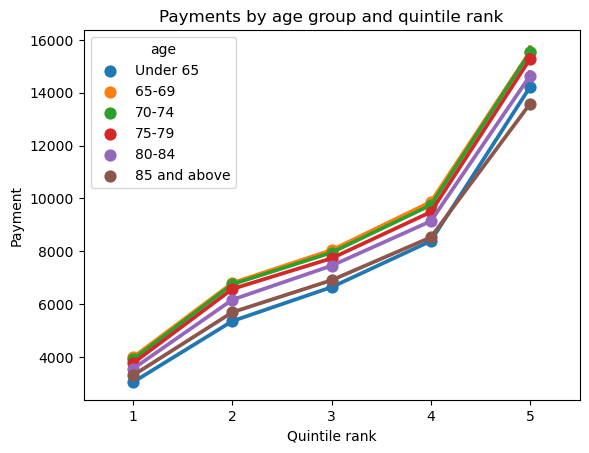

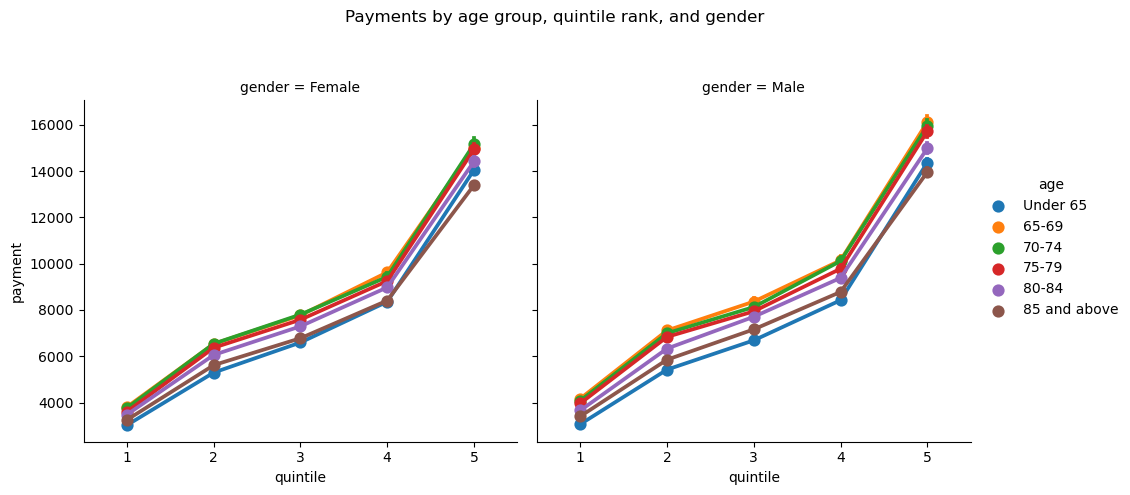

In [13]:
# Calculate the total expenditures for each age group
age_pay_sum = data.groupby('age')['payment'].sum()

# Calculate the percentage of total expenditures for each age group
age_pay_pct = age_pay_sum / age_pay_sum.sum() * 100

# Plot the percentage of total expenditures for each age group using a bar plot
sns.barplot(x=age_pay_pct.index, y=age_pay_pct)
plt.xlabel('Age group')
plt.ylabel('Percentage of total expenditures')
plt.title('Distribution of Expenditures by Age Group')
plt.show()

# Create a new column that indicates the quintile range for each observation
data['quintile_range'] = pd.cut(data['quintile'], bins=[1, 2, 3, 4, 5, 6],
                                labels=['1-20%', '21-40%', '41-60%', '61-80%',
                                        '81-100%'])

# Create a point plot to show the average payments by age group quintile rank
sns.pointplot(x='quintile', y='payment', hue='age', data=data)
plt.xlabel('Quintile rank')
plt.ylabel('Payment')
plt.title('Payments by age group and quintile rank')

sns.catplot(x='quintile', y='payment', hue='age',
            col='gender', data=data, kind='point')
plt.subplots_adjust(top=0.8)
plt.suptitle('Payments by age group, quintile rank, and gender')

# Show the chart
plt.show()

## Expenditures, length of stay, and age.

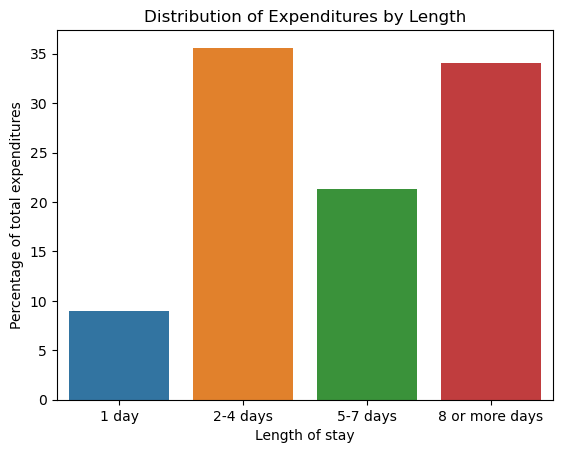

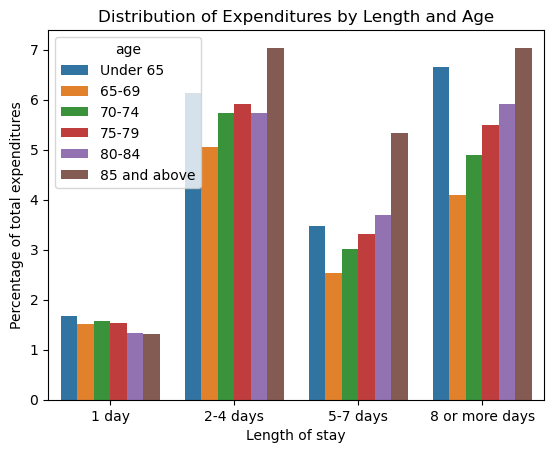

In [14]:
# Calculate the total expenditures by length of stay
length_pay_sum = data.groupby('length')['payment'].sum()

# Calculate the percentage of total expenditures for each age group
length_pay_pct = length_pay_sum / length_pay_sum.sum() * 100

# Plot the percentage of total expenditures for each age group using a bar plot
sns.barplot(x=length_pay_pct.index, y=length_pay_pct)
plt.xlabel('Length of stay')
plt.ylabel('Percentage of total expenditures')
plt.title('Distribution of Expenditures by Length')
plt.show()

# Calculate the total expenditures by length of stay and age category
length_age_pay_sum = data.groupby(['length', 'age'])['payment'].sum()

# Calculate the percentage of total expenditures for each length and age group
length_age_pay_pct = length_age_pay_sum / length_age_pay_sum.sum() * 100

# Reset the index to make the length of stay and age categories into columns
length_age_pay_pct = length_age_pay_pct.reset_index()

# Cluster bar plot the percentage of total expenditures for stay and age group
sns.barplot(x='length', y='payment', hue='age', data=length_age_pay_pct)
plt.xlabel('Length of stay')
plt.ylabel('Percentage of total expenditures')
plt.title('Distribution of Expenditures by Length and Age')
plt.show()

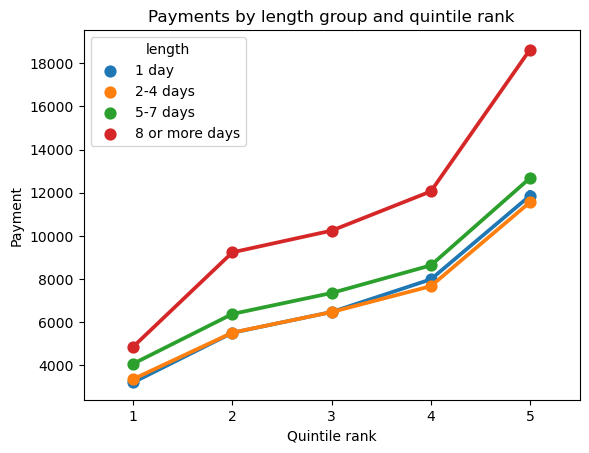

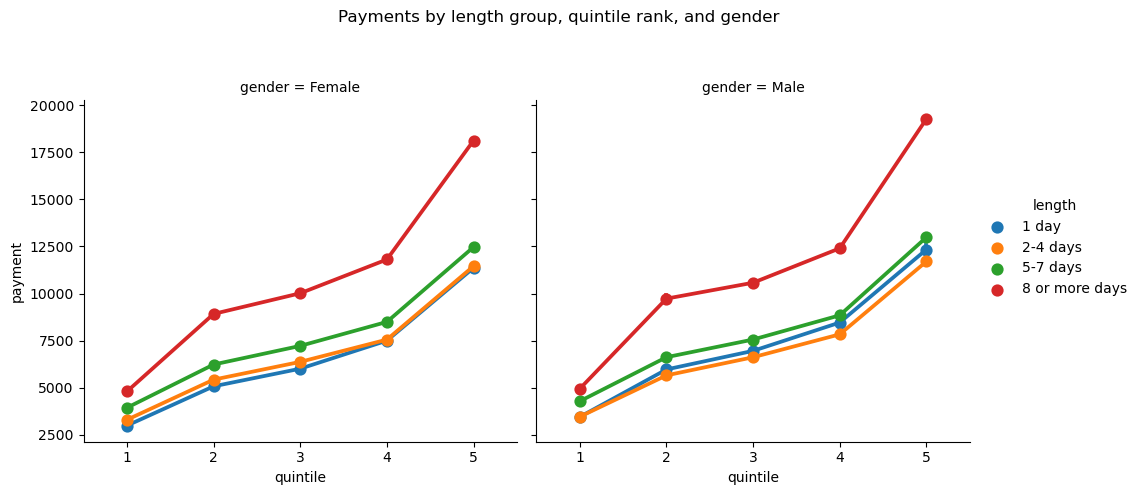

In [15]:
# Create a new column that indicates the quintile range for each observation
data['quintile_range'] = pd.cut(data['quintile'], bins=[1, 2, 3, 4, 5, 6],
                                labels=['1-20%', '21-40%', '41-60%', '61-80%',
                                        '81-100%'])

# Create a point plot to show the average payments by length and quintile
sns.pointplot(x='quintile', y='payment', hue='length', data=data)
plt.xlabel('Quintile rank')
plt.ylabel('Payment')
plt.title('Payments by length group and quintile rank')

sns.catplot(x='quintile', y='payment', hue='length',
            col='gender', data=data, kind='point')
plt.subplots_adjust(top=0.8)

plt.suptitle('Payments by length group, quintile rank, and gender')
plt.show()

## Expenditures for specific procedures

icd9
81.0    13.499553
45.0     9.411619
96.0     8.828847
0.0      8.630961
39.0     8.198756
Name: payment, dtype: float64


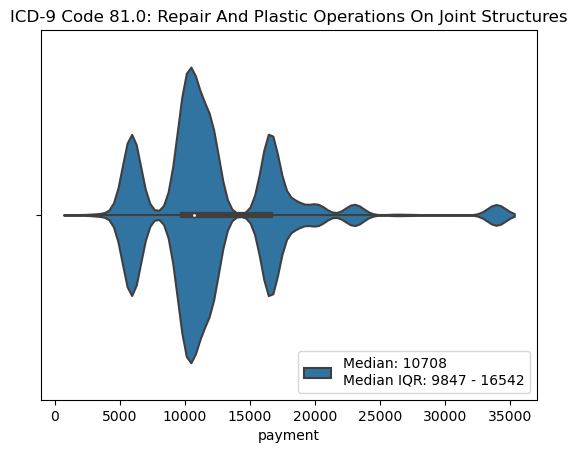

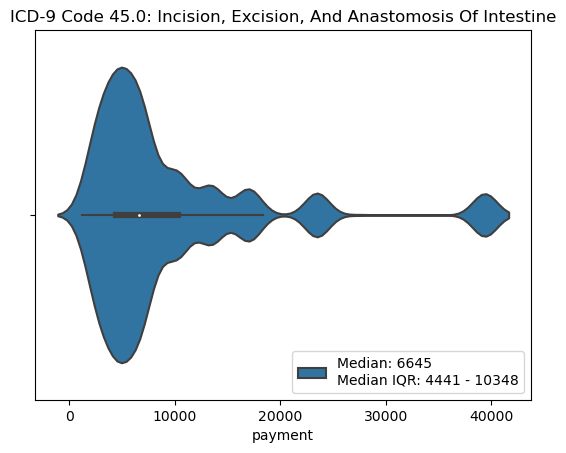

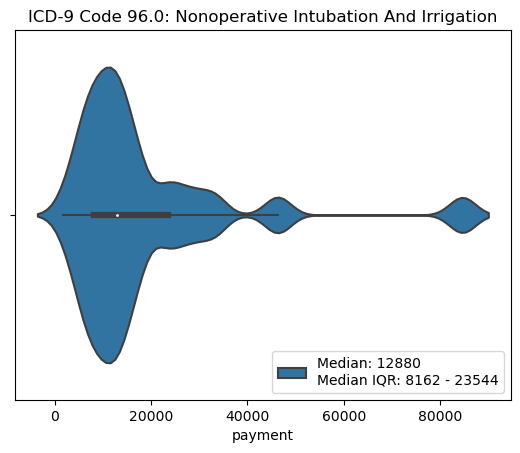

In [16]:
# Calculate the total expenditures by icd9code
icd9_pay_sum = data.groupby('icd9')['payment'].sum()

# Calculate the percentage of total expenditures for each icd9 group
icd9_pay_pct = icd9_pay_sum / icd9_pay_sum.sum() * 100

# Display the top percentage codes:
print(icd9_pay_pct.sort_values(ascending=False).head())


# Create a new column that indicates the quintile range for each observation
top_3_icd9_pay_pct = icd9_pay_pct.sort_values(ascending=False).head(3)

for icd9_code in top_3_icd9_pay_pct.index:
    icd9_data = data[data['icd9'] == icd9_code]
    ax = sns.violinplot(x='payment', data=icd9_data)

    # Set the plot title to 'Code xx: descriptor'
    descriptor = icd9_data.iloc[0]['descriptor_icd']
    ax.set_title(f'ICD-9 Code {icd9_code}: {descriptor}')

    # Add legend with median and median IQR values to bottom right of box plot
    median = np.median(icd9_data['payment'])
    iqr_25, iqr_75 = np.percentile(icd9_data['payment'], [25, 75])
    legend_text = f'Median: {median:.0f}\nMedian IQR: {iqr_25:.0f} - {iqr_75:.0f}'
    ax.legend([legend_text], loc='lower right')

    # Show the box plot
    plt.show()

# Insights and Findings

## Key insights
In our exploratory data analysis, we uncovered several interesting insights related to healthcare expenditures in the CMS 2008 BSA Inpatient Claims dataset:

Chi-square tables: We cannot say there are significant associations between pairs of gender, age, and length of stay

Highest expenditures: The top three DRGs with the highest expenditures were codes 298, 148, and 272, which we identified in the data filtering and preprocessing stage.

Gender: Healthcare expenditures were higher for women, accounting for 55.3% of total spending, compared to 45% for men. This is consistent with the sample population, which is composed of 56.7% women and 43.3% men.

Age: The largest share of healthcare payments is allocated to the group aged 85 and above. Although their average payment per DRG code is lower, expenditures generally increase as the age category goes up. This trend holds true across both genders.

Length of Stay: Most claims fall into the 2-4 day or the 8+ day ranges. Healthcare expenditures increase as the length of stay goes up, which is expected. No significant differences were observed across genders or age groups in this regard.

Expenditures for Specific Procedures: Many procedures exhibit a long right tail in their distribution of expenditures, indicating the presence of expensive outliers. After filtering the initial dataset, the top three procedure codes associated with the highest spending are 81 (Joint Repairs), 37 (Other Heart Operations), and 45 (Intestinal).

## Potential limitations
While our analysis has revealed interesting trends and patterns, it is crucial to consider the limitations of the dataset:

The dataset has undergone significant preprocessing, including filtering based on DRGs and suppression of certain variables to preserve confidentiality. This may affect the generalizability of our findings to the broader Medicare population.

We have focused on a subset of DRGs with a significant number of claims and low suppression rates, which might not represent the full spectrum of healthcare expenditures.

Our analysis is primarily descriptive and does not establish causal relationships between variables. Further investigation, such as using regression models, would be required to understand the impact of factors like age, gender, or length of stay on healthcare expenditures.

Some of the observed trends could be influenced by external factors not captured in the dataset, such as regional differences in healthcare costs, changing healthcare policies, or fluctuations in the economy.

Despite these limitations, our exploratory data analysis provides valuable insights into healthcare expenditures across different demographic groups, lengths of stay, and specific procedures, which can inform future research and healthcare policy decisions.

# Conclusion

## Recap
This project examined public Medicare claims data to analyze expenditures across various demographics and diagnosis-related groups (DRGs).  We discovered several interesting insights. Healthcare expenditures were higher for women, accounting for 55.3% of total spending. The largest share of healthcare payments went to the group aged 85 and above, with expenditures generally increasing as age goes up. Most claims fall into the 2-4 day or the 8+ day length of stay ranges, and expenditures increase as the length of stay goes up..  The top procedure codes with the highest spending are 81 (Joint Repairs), 37 (Other Heart Operations), and 45 (Intestinal). Our chi-square tests did not reveal significant associations between pairs of gender, age, and length of stay.

## Possible next steps
Subgroup analysis: Dive deeper into specific DRGs or procedure codes to better understand how expenditures vary within those categories. This can include exploring the impact of factors like age and gender on healthcare costs for these specific groups.

Predictive modeling: Create a machine learning model that predicts healthcare expenditures based on demographic factors, DRG codes, procedure codes, and other important variables. This can help uncover patterns and risk factors tied to high healthcare costs, allowing for more focused interventions and resource allocation.

Association rule mining: Use association rule mining techniques to find connections between different variables in the dataset, such as age, gender, DRG codes, and procedure codes. This can help identify interesting patterns and relationships that might not be obvious through traditional statistical methods.